In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, glob, joblib
from torch.autograd import grad
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, confusion_matrix


In [2]:
import numpy as np
import torch

data_path = "/home/bhagya/Data_Bhagya_internship_wav2vec_xlsr_IIITH_23L/23lang_wav2_vec_features/"
languages = ["Assamese", "Bengali", "Bodo", "Dogri", "English", "Gujarati", "Hindi", "Kannada",
             "Kashmiri", "Konkani", "Maithili", "Malayalam", "Manipuri", "Marathi", "Nepali",
             "Odia", "Punjabi", "Sanskrit", "Santali", "Sindhi", "Tamil", "Telugu", "Urdu"]

# Define indices for Indo-Aryan and Dravidian languages
indo_aryan_indices = [languages.index(lang) for lang in ["Hindi", "Bengali", "Marathi", "Punjabi"]]
dravidian_indices = [languages.index(lang) for lang in ["Telugu", "Tamil", "Malayalam"]]
kannada_index = languages.index("Kannada")

# Function to load data for each language
def load_language_data(language):
    X_train_lang = np.load(data_path + f"X_train_original_VAD30_wav2vec2_xlsr_small_last16_cms_{language}.npy")
    y_train_lang = np.load(data_path + f"y_train_original_VAD30_wav2vec2_xlsr_small_last16_cms_{language}.npy")
    X_test_lang = np.load(data_path + f"X_test_original_VAD30_wav2vec2_xlsr_small_last16_cms_{language}.npy")
    y_test_lang = np.load(data_path + f"y_test_original_VAD30_wav2vec2_xlsr_small_last16_cms_{language}.npy")
    return X_train_lang, y_train_lang, X_test_lang, y_test_lang

# Filter and balance the Indo-Aryan and Dravidian samples for training
def filter_and_label_data(X, y, indo_aryan_indices, dravidian_indices):
    indo_aryan_mask = np.isin(y, indo_aryan_indices)
    dravidian_mask = np.isin(y, dravidian_indices)

    X_indo_aryan = X[indo_aryan_mask]
    y_indo_aryan = y[indo_aryan_mask]

    X_dravidian = X[dravidian_mask]
    y_dravidian = y[dravidian_mask]

    # Adjust the sample size for the North set to balance with the South set
    X_indo_aryan = X_indo_aryan[::3]
    y_indo_aryan = y_indo_aryan[::3]

    # Create binary labels
    X_binary = np.concatenate((X_indo_aryan, X_dravidian), axis=0)
    y_binary = np.concatenate((np.zeros(len(X_indo_aryan)), np.ones(len(X_dravidian))), axis=0)  # Indo-Aryan: 0, Dravidian: 1

    return X_binary, y_binary

# Function to filter Kannada samples for validation
def filter_kannada_data(X, y, kannada_index):
    kannada_mask = (y == kannada_index)
    X_kannada = X[kannada_mask]
    y_kannada = y[kannada_mask]

    y_kannada_binary = np.ones(len(y_kannada))  # Kannada is Dravidian: 1
    return X_kannada, y_kannada_binary

# Load and concatenate data for Indo-Aryan and Dravidian languages
X_train_all = []
y_train_all = []
for lang in ["Hindi", "Bengali", "Marathi", "Punjabi", "Telugu", "Tamil", "Malayalam"]:
    X_lang, y_lang, _, _ = load_language_data(lang)
    X_train_all.append(X_lang)
    y_train_all.append(y_lang)

X_train_all = np.concatenate(X_train_all, axis=0)
y_train_all = np.concatenate(y_train_all, axis=0)

X_train, y_train = filter_and_label_data(X_train_all, y_train_all, indo_aryan_indices, dravidian_indices)

# Filter Kannada samples for validation
X_valid_train, y_valid_train, X_valid_test, y_valid_test = load_language_data("Kannada")
X_valid, y_valid = filter_kannada_data(X_valid_train, y_valid_train, kannada_index)

# Assuming xv_data_manage is a function to preprocess data
def xv_data_manage(X):
    # Add preprocessing steps here
    return X

X_train = xv_data_manage(X_train)
X_valid = xv_data_manage(X_valid)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_valid_tensor = torch.tensor(X_valid, dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid, dtype=torch.long)

# Check that we've recovered the right data
print(f'X_train: {X_train.shape}, y_train: {y_train.shape}')
print(f'X_valid: {X_valid.shape}, y_valid: {y_valid.shape}')


X_train: (5095, 300, 1024), y_train: (5095,)
X_valid: (1205, 300, 1024), y_valid: (1205,)


In [3]:
#ecapa noramal
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import math
import sys
sys.path.insert(0, "/home/bhagya/asv-subtools-master/pytorch/")
import libs.support.utils as utils
from libs.nnet import *

# refs:
# 1.  ECAPA-TDNN: Emphasized Channel Attention, Propagation and Aggregation in TDNN Based Speaker Verification
#           https://arxiv.org/abs/2005.07143
# 2.  Unofficial implementation of the ECAPA-TDNN model.
#       https://github.com/lawlict/ECAPA-TDNN




''' Res2Conv1d + BatchNorm1d + ReLU
'''
class Res2Conv1dReluBn(nn.Module):
    '''
    inputs_dim == out_channels == channels
    '''
    def __init__(self, channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False, scale=4):
        super().__init__()
        assert channels % scale == 0, "{} % {} != 0".format(channels, scale)
        self.scale = scale
        self.width = channels // scale
        self.nums = scale if scale == 1 else scale - 1

        self.convs = []
        self.bns = []
        for i in range(self.nums):
            self.convs.append(nn.Conv1d(self.width, self.width, kernel_size, stride, padding, dilation, bias=bias))
            self.bns.append(nn.BatchNorm1d(self.width))
        self.convs = nn.ModuleList(self.convs)
        self.bns = nn.ModuleList(self.bns)

    def forward(self, x):
        out = []
        spx = torch.split(x, self.width, 1)
        for i in range(self.nums):
            if i == 0:
                sp = spx[i]
            else:
                sp = sp + spx[i]
            # Order: conv -> relu -> bn
            sp = self.convs[i](sp)
            sp = self.bns[i](F.relu(sp))
            out.append(sp)
        if self.scale != 1:
            out.append(spx[self.nums])
        out = torch.cat(out, dim=1)
        return out



''' Conv1d + BatchNorm1d + ReLU
'''
class Conv1dReluBn(nn.Module):
    def __init__(self, inputs_dim, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False):
        super().__init__()
        self.conv = nn.Conv1d(inputs_dim, out_channels, kernel_size, stride, padding, dilation, bias=bias)
        self.bn = nn.BatchNorm1d(out_channels)

    def forward(self, x):
        return self.bn(F.relu(self.conv(x)))



''' The SE connection of 1D case.
'''
class SE_Connect(nn.Module):
    def __init__(self, channels, s=4):
        super().__init__()
        assert channels % s == 0, "{} % {} != 0".format(channesl, s)
        self.linear1 = nn.Linear(channels, channels // s)
        self.linear2 = nn.Linear(channels // s, channels)

    def forward(self, x):
        out = x.mean(dim=2)
        out = F.relu(self.linear1(out))
        out = torch.sigmoid(self.linear2(out))
        out = x * out.unsqueeze(2)
        return out

#Another implementation of SE_Connect
# class SE_Connect(nn.Module):
#     def __init__(self, channels, bottleneck=128):
#         super(SE_Connect, self).__init__()
#         self.se = nn.Sequential(
#             nn.AdaptiveAvgPool1d(1),
#             nn.Conv1d(channels, bottleneck, kernel_size=1, padding=0),
#             nn.ReLU(),
#             # nn.BatchNorm1d(bottleneck),
#             nn.Conv1d(bottleneck, channels, kernel_size=1, padding=0),
#             nn.Sigmoid(),
#             )

#     def forward(self, input):
#         x = self.se(input)
#         return input * x


''' SE-Res2Block.
    Note: residual connection is implemented in the ECAPA_TDNN model, not here.
'''
def SE_Res2Block(channels, kernel_size, stride, padding, dilation, scale):
    return nn.Sequential(
        Conv1dReluBn(channels, channels, kernel_size=1, stride=1, padding=0),
        Res2Conv1dReluBn(channels, kernel_size, stride, padding, dilation, scale=scale),
        Conv1dReluBn(channels, channels, kernel_size=1, stride=1, padding=0),
        SE_Connect(channels)
    )



''' Attentive weighted mean and standard deviation pooling.
'''
class AttentiveStatsPool(nn.Module):
    def __init__(self, in_dim, bottleneck_dim):
        super().__init__()
        # Use Conv1d with stride == 1 rather than Linear, then we don't need to transpose inputs.
        self.linear1 = nn.Conv1d(in_dim, bottleneck_dim, kernel_size=1) # equals W and b in the paper
        self.linear2 = nn.Conv1d(bottleneck_dim, in_dim, kernel_size=1) # equals V and k in the paper

    def forward(self, x):
        # DON'T use ReLU here! In experiments, I find ReLU hard to converge.
        alpha = torch.tanh(self.linear1(x))
        alpha = torch.softmax(self.linear2(alpha), dim=2)
        mean = torch.sum(alpha * x, dim=2)
        residuals = torch.sum(alpha * x ** 2, dim=2) - mean ** 2
        std = torch.sqrt(residuals.clamp(min=1e-9))
        return torch.cat([mean, std], dim=1)



''' Implementation of
    "ECAPA-TDNN: Emphasized Channel Attention, Propagation and Aggregation in TDNN Based Speaker Verification".

    Note that we DON'T concatenate the last frame-wise layer with non-weighted mean and standard deviation,
    because it brings little improvment but significantly increases model parameters.
    As a result, this implementation basically equals the A.2 of Table 2 in the paper.
'''
class ECAPA_TDNN(TopVirtualNnet):
    def init(self, inputs_dim, num_targets, channels=512, embd_dim=192,
             aug_dropout=0.5, tail_dropout=0.5, training=True,
             extracted_embedding="near", mixup=False, mixup_alpha=1.0,
             pooling="ecpa-attentive", pooling_params={}, fc1=False, fc1_params={}, fc2_params={},
             margin_loss= True, margin_loss_params={}, use_step=False, step_params={}, transfer_from="softmax_loss" ):


        default_pooling_params = {
            "num_head":1,
            "hidden_size":64,
            "share":True,
            "affine_layers":1,
            "context":[0],
            "stddev":True,
            "temperature":False,
            "fixed":True
        }

        default_fc_params = {
            "nonlinearity":'relu', "nonlinearity_params":{"inplace":True},
            "bn-relu":False,
            "bn":True,
            "bn_params":{"momentum":0.5, "affine":True, "track_running_stats":True}
            }


        default_margin_loss_params = {
            "method":"am", "m":0.2,
            "feature_normalize":True, "s":30,
            "double":False,
            "mhe_loss":False, "mhe_w":0.01,
            "inter_loss":0.,
            "ring_loss":0.,
            "curricular":False}

        default_step_params = {
            "T":None,
            "m":False, "lambda_0":0, "lambda_b":1000, "alpha":5, "gamma":1e-4,
            "s":False, "s_tuple":(30, 12), "s_list":None,
            "t":False, "t_tuple":(0.5, 1.2),
            "p":False, "p_tuple":(0.5, 0.1)
        }

        self.use_step = use_step
        self.step_params = step_params
        self.extracted_embedding = extracted_embedding

        pooling_params = utils.assign_params_dict(default_pooling_params, pooling_params)
        fc1_params = utils.assign_params_dict(default_fc_params, fc1_params)
        fc2_params = utils.assign_params_dict(default_fc_params, fc2_params)
        margin_loss_params = utils.assign_params_dict(default_margin_loss_params, margin_loss_params)
        step_params = utils.assign_params_dict(default_step_params, step_params)


        #self.mixup = Mixup(alpha=mixup_alpha) if mixup else None
        #self.pcmvn = AdaptivePCMN(20)
        self.layer1 = Conv1dReluBn(inputs_dim, channels, kernel_size=5, padding=2)
        self.layer2 = SE_Res2Block(channels, kernel_size=3, stride=1, padding=2, dilation=2, scale=8)
        self.layer3 = SE_Res2Block(channels, kernel_size=3, stride=1, padding=3, dilation=3, scale=8)
        self.layer4 = SE_Res2Block(channels, kernel_size=3, stride=1, padding=4, dilation=4, scale=8)
        cat_channels = channels * 3
        self.conv = nn.Conv1d(cat_channels, cat_channels, kernel_size=1)
        self.bn_conv = nn.BatchNorm1d(cat_channels)

        # Pooling
        stddev = pooling_params.pop("stddev")
        if pooling == "attentive":
            self.stats = AttentiveStatisticsPooling(cat_channels, hidden_size=pooling_params["hidden_size"],context=pooling_params["context"], stddev=stddev)
            self.bn_stats = nn.BatchNorm1d(cat_channels * 2)
            self.fc1 = ReluBatchNormTdnnLayer(cat_channels * 2, embd_dim, **fc1_params) if fc1 else None
        elif pooling == "ecpa-attentive":
            self.stats = AttentiveStatsPool(cat_channels,128)
            self.bn_stats = nn.BatchNorm1d(cat_channels * 2)
            self.fc1 = ReluBatchNormTdnnLayer(cat_channels * 2, embd_dim, **fc1_params) if fc1 else None
        elif pooling == "multi-head":
            self.stats = MultiHeadAttentionPooling(cat_channels, stddev=stddev, **pooling_params)
            self.bn_stats = nn.BatchNorm1d(cat_channels * 2)
            self.fc1 = ReluBatchNormTdnnLayer(cat_channels * 2, embd_dim, **fc1_params) if fc1 else None
        elif pooling == "global-multi":
            self.stats = GlobalMultiHeadAttentionPooling(cat_channels,stddev=stddev, **pooling_params)
            self.bn_stats = nn.BatchNorm1d(cat_channels * 2* pooling_params["num_head"])
            self.fc1 = ReluBatchNormTdnnLayer(cat_channels * 2* pooling_params["num_head"], embd_dim, **fc1_params) if fc1 else None
        elif pooling == "multi-resolution":
            self.stats = MultiResolutionMultiHeadAttentionPooling(cat_channels, **pooling_params)
            self.bn_stats = nn.BatchNorm1d(cat_channels * 2* pooling_params["num_head"])
            self.fc1 = ReluBatchNormTdnnLayer(cat_channels * 2* pooling_params["num_head"], embd_dim, **fc1_params) if fc1 else None

        else:
            self.stats = StatisticsPooling(cat_channels, stddev=stddev)
            self.bn_stats = nn.BatchNorm1d(cat_channels * 2)
            self.fc1 = ReluBatchNormTdnnLayer(cat_channels * 2, embd_dim, **fc1_params) if fc1 else None

        self.tail_dropout = torch.nn.Dropout2d(p=tail_dropout) if tail_dropout > 0 else None

        if fc1:
            fc2_in_dim = embd_dim
        else:
            fc2_in_dim = cat_channels * 2
        self.fc2 = ReluBatchNormTdnnLayer(fc2_in_dim, embd_dim, **fc2_params)
        self.tail_dropout = torch.nn.Dropout2d(p=tail_dropout) if tail_dropout > 0 else None

         # Loss
        # Do not need when extracting embedding.
        if training :
            if margin_loss:
                self.loss = MarginSoftmaxLoss(embd_dim, num_targets, **margin_loss_params)
            else:
                self.loss = SoftmaxLoss(embd_dim, num_targets)
                # self.loss = AngleLoss(embd_dim,num_targets)
            self.wrapper_loss = MixupLoss(self.loss, self.mixup) if mixup else None
            # An example to using transform-learning without initializing loss.affine parameters
            self.transform_keys = ["layer2","layer3","layer4","conv","stats","fc1","fc2"]

            if margin_loss and transfer_from == "softmax_loss":
                # For softmax_loss to am_softmax_loss
                self.rename_transform_keys = {"loss.affine.weight":"loss.weight"}

    @utils.for_device_free
    def forward(self, x):
        #x = self.mixup(x)
        #x = self.pcmvn(x)
        out1 = self.layer1(x)
        out2 = self.layer2(out1) + out1
        out3 = self.layer3(out1 + out2) + out1 + out2
        out4 = self.layer4(out1 + out2 + out3) + out1 + out2 + out3
        out = torch.cat([out2, out3, out4], dim=1)
        out = self.bn_conv(F.relu(self.conv(out)))
        x = self.bn_stats(self.stats(out))
        if len(x.shape) !=3:
            x = x.unsqueeze(dim=2)
        x = self.auto(self.fc1, x)
        x = self.fc2(x)
        x = self.auto(self.tail_dropout, x)
        return x

    @utils.for_device_free
    def get_loss(self, inputs, targets):
        """Should call get_loss() after forward() with using Xvector model function.
        e.g.:
            m=Xvector(20,10)
            loss=m.get_loss(m(inputs),targets)

        model.get_loss [custom] -> loss.forward [custom]
          |
          v
        model.get_accuracy [custom] -> loss.get_accuracy [custom] -> loss.compute_accuracy [static] -> loss.predict [static]
        """
        if self.wrapper_loss is not None:
            return self.wrapper_loss(inputs, targets)
        else:
            return self.loss(inputs, targets)

    @utils.for_device_free
    def get_accuracy(self, targets):
        """Should call get_accuracy() after get_loss().
        @return: return accuracy
        """
        if self.wrapper_loss is not None:
            return self.wrapper_loss.get_accuracy(targets)
        else:
            return self.loss.get_accuracy(targets)

    @for_extract_embedding(maxChunk=10000, isMatrix=True)
    def extract_embedding(self, inputs):
        out1 = self.layer1(inputs)
        out2 = self.layer2(out1) + out1
        out3 = self.layer3(out1 + out2) + out1 + out2
        out4 = self.layer4(out1 + out2 + out3) + out1 + out2 + out3
        out = torch.cat([out2, out3, out4], dim=1)
        out = self.bn_conv(F.relu(self.conv(out)))
        x = self.bn_stats(self.stats(out))
        if len(x.shape) !=3:
            x = x.unsqueeze(dim=2)
        if self.extracted_embedding == "far":
            assert self.fc1 is not None
            xvector = self.fc1.affine(x)
        elif self.extracted_embedding == "near_affine":
            x = self.auto(self.fc1, x)
            xvector = self.fc2.affine(x)
        elif self.extracted_embedding == "near":
            x = self.auto(self.fc1, x)
            xvector = self.fc2(x)
        else:
            raise TypeError("Expected far or near position, but got {}".format(self.extracted_embedding))
        return xvector

    def get_warmR_T(T_0, T_mult, epoch):
        n = int(math.log(max(0.05, (epoch / T_0 * (T_mult - 1) + 1)), T_mult))
        T_cur = epoch - T_0 * (T_mult ** n - 1) / (T_mult - 1)
        T_i = T_0 * T_mult ** (n)
        return T_cur, T_i

    def compute_decay_value(self, start, end, T_cur, T_i):
        # Linear decay in every cycle time.
        return start - (start - end)/(T_i-1) * (T_cur%T_i)

    def step(self, epoch, this_iter, epoch_batchs):
        # Heated up for t and s.
        # Decay for margin and dropout p.
        if self.use_step:
            if self.step_params["m"]:
                current_postion = epoch*epoch_batchs + this_iter
                lambda_factor = max(self.step_params["lambda_0"],
                                 self.step_params["lambda_b"]*(1+self.step_params["gamma"]*current_postion)**(-self.step_params["alpha"]))
                self.loss.step(lambda_factor)

            if self.step_params["T"] is not None and (self.step_params["t"] or self.step_params["p"]):
                T_cur, T_i = get_warmR_T(*self.step_params["T"], epoch)
                T_cur = T_cur*epoch_batchs + this_iter
                T_i = T_i * epoch_batchs

            if self.step_params["t"]:
                self.loss.t = self.compute_decay_value(*self.step_params["t_tuple"], T_cur, T_i)

            if self.step_params["p"]:
                self.aug_dropout.p = self.compute_decay_value(*self.step_params["p_tuple"], T_cur, T_i)

            if self.step_params["s"]:
                self.loss.s = self.step_params["s_tuple"][self.step_params["s_list"][epoch]]


if __name__ == '__main__':
    # Input size: batch_size * seq_len * feat_dim
    x = torch.zeros(2, 20, 300)
    model = ECAPA_TDNN(inputs_dim=20,num_targets=5, channels=512, embd_dim=192)
    out = model(x)
    print(model)
    print(out.shape)    # should be [2, 192]

ECAPA_TDNN(
  (layer1): Conv1dReluBn(
    (conv): Conv1d(20, 512, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
    (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Conv1dReluBn(
      (conv): Conv1d(512, 512, kernel_size=(1,), stride=(1,), bias=False)
      (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Res2Conv1dReluBn(
      (convs): ModuleList(
        (0-6): 7 x Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,), bias=False)
      )
      (bns): ModuleList(
        (0-6): 7 x BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): Conv1dReluBn(
      (conv): Conv1d(512, 512, kernel_size=(1,), stride=(1,), bias=False)
      (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): SE_Connect(
      (linear1): Linear(in_features=512

/home/bhagya/miniconda3/envs/env1/lib/python3.11/site-packages/torch/nn/functional.py:1381: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn("dropout2d: Received a 3D input to dropout2d and assuming that channel-wise "


In [4]:
def xv_data_manage(X_test):
    aa = X_test.transpose((0, 2, 1))
    print(X_test.shape, '-->', aa.shape)
    return aa

In [5]:
X_train = xv_data_manage(X_train)
X_valid = xv_data_manage(X_valid)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_valid_tensor = torch.tensor(X_valid, dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid, dtype=torch.long)

(5095, 300, 1024) --> (5095, 1024, 300)
(1205, 300, 1024) --> (1205, 1024, 300)


In [6]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
#deice=torch.device("cpu")
model = ECAPA_TDNN(1024,2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)#, weight_decay=0.0000001, betas=(0.9, 0.98), eps=1e-9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=1e-8, eps=1e-08, verbose=True)

/home/bhagya/miniconda3/envs/env1/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [7]:
trainloader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), shuffle=True, batch_size=256, drop_last=False)
testloader1 = DataLoader(TensorDataset(X_valid_tensor, y_valid_tensor), shuffle=True, batch_size=64, drop_last=False)

#testloader2 = torch.utils.data.DataLoader(list(zip(X_test,y_test)), shuffle=True, batch_size=32,drop_last=False)
print(len(trainloader))
print(len(testloader1))
#print(len(testloader2))
#print(len(testloader3))

20
19


In [8]:
np.unique(y_valid,return_counts =True)

(array([1.]), array([1205]))

In [9]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import cf_matrix


Epoch: 0, Batch: 0, Loss: 5.700839042663574, Accuracy: 55.859375%
Total training loss 1.3696605071425438 and training Accuracy 90.87340529931305% after 0 epochs
#####TEST--in-domain:::::Epoch: 0, Batch: 0, Loss: 0.21376490592956543, Accuracy:96.875%


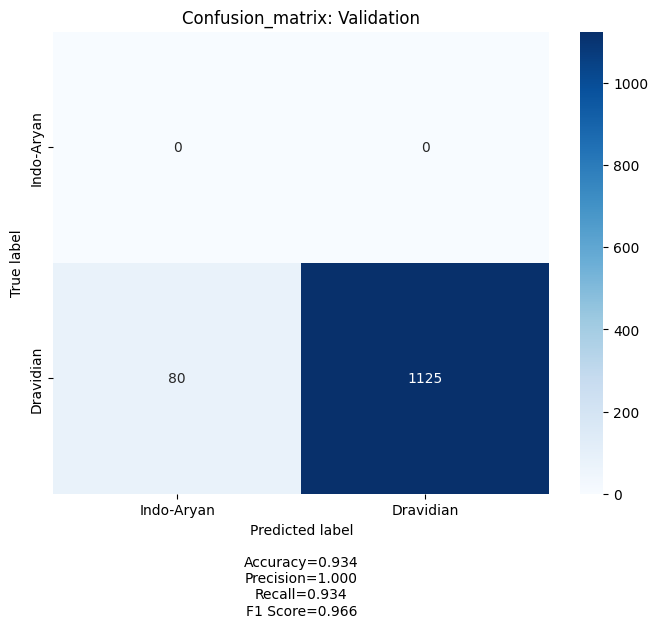

:::::Total validation loss 0.29953996954779877, Training accuracy 90.87340529931305%, Validation accuracy 93.3609958506224% after 0 epochs
Epoch: 1, Batch: 0, Loss: 0.2872783839702606, Accuracy: 98.046875%
Total training loss 0.1425145163666457 and training Accuracy 99.17566241413151% after 1 epochs
#####TEST--in-domain:::::Epoch: 1, Batch: 0, Loss: 1.4771981239318848, Accuracy:89.0625%


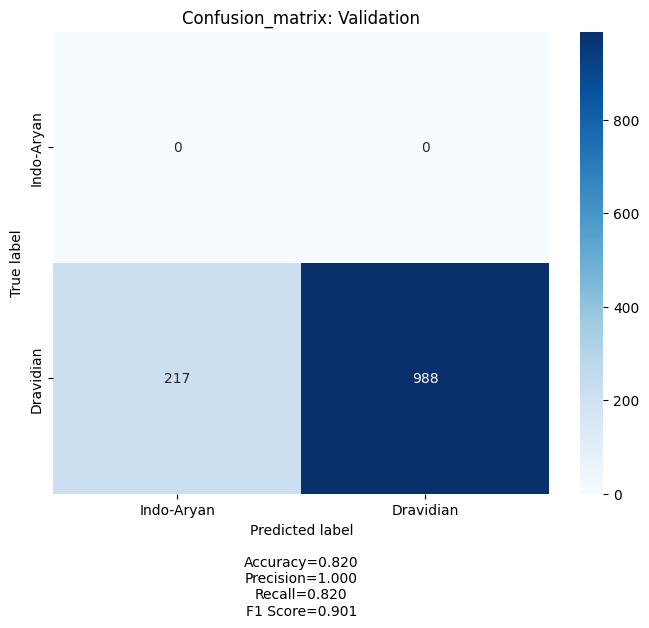

:::::Total validation loss 2.454876687965895, Training accuracy 99.17566241413151%, Validation accuracy 81.99170124481327% after 1 epochs
Epoch: 2, Batch: 0, Loss: 0.016131926327943802, Accuracy: 100.0%
Total training loss 0.07851036641513928 and training Accuracy 99.48969578017665% after 2 epochs
#####TEST--in-domain:::::Epoch: 2, Batch: 0, Loss: 8.151972770690918, Accuracy:53.125%


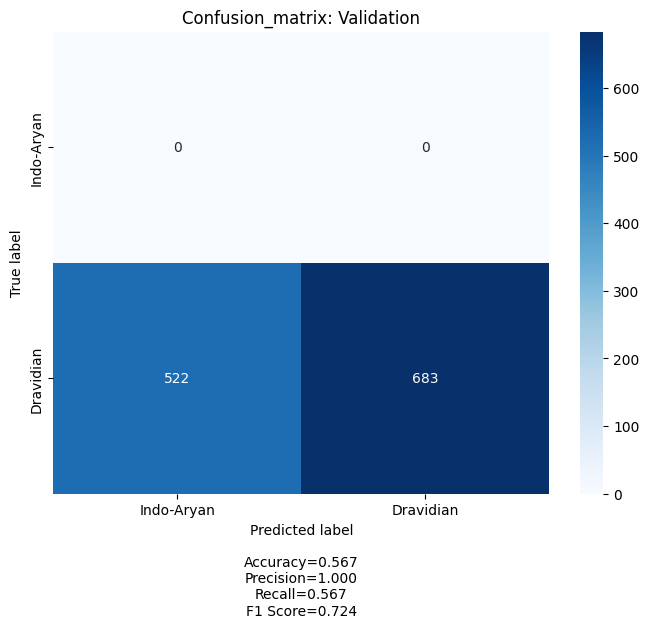

:::::Total validation loss 8.400126657987895, Training accuracy 99.48969578017665%, Validation accuracy 56.6804979253112% after 2 epochs
Epoch: 3, Batch: 0, Loss: 0.003198155201971531, Accuracy: 100.0%
Total training loss 0.06302797001553699 and training Accuracy 99.68596663395486% after 3 epochs
#####TEST--in-domain:::::Epoch: 3, Batch: 0, Loss: 3.00508451461792, Accuracy:81.25%


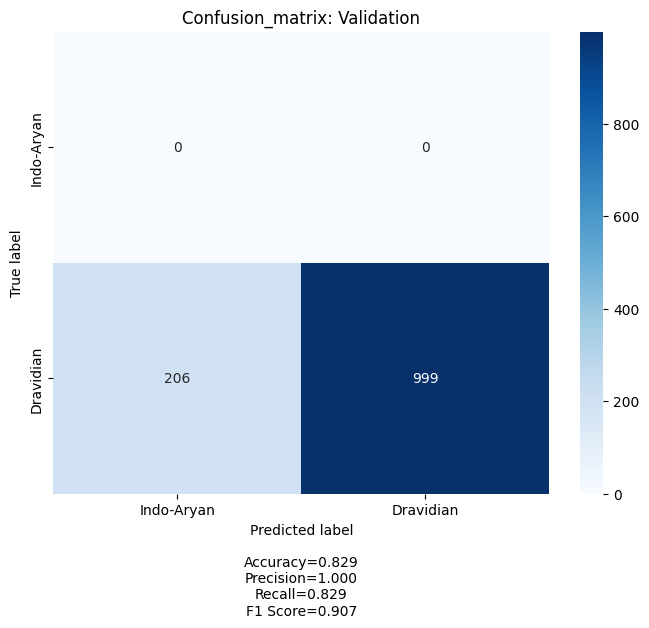

:::::Total validation loss 2.8416418276335063, Training accuracy 99.68596663395486%, Validation accuracy 82.9045643153527% after 3 epochs
Epoch: 4, Batch: 0, Loss: 0.0010732549708336592, Accuracy: 100.0%
Total training loss 0.010916177542276273 and training Accuracy 100.0% after 4 epochs
#####TEST--in-domain:::::Epoch: 4, Batch: 0, Loss: 4.9192728996276855, Accuracy:70.3125%


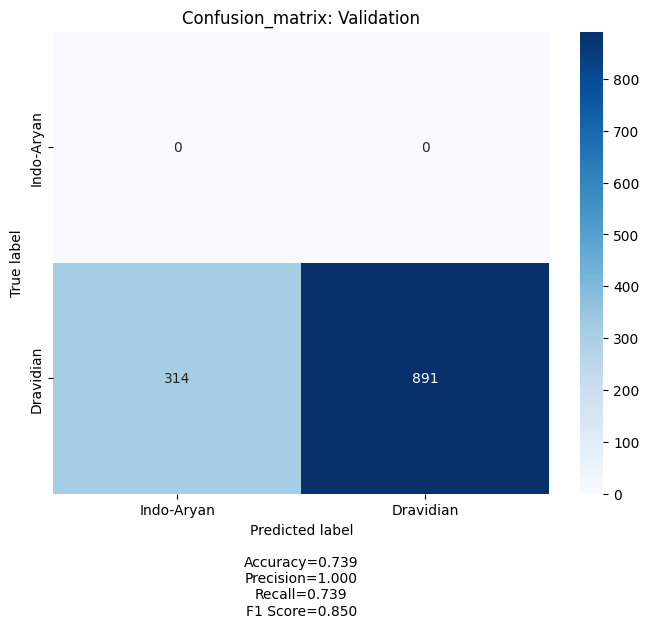

:::::Total validation loss 4.732439555619893, Training accuracy 100.0%, Validation accuracy 73.94190871369295% after 4 epochs
Epoch: 5, Batch: 0, Loss: 0.0013458086177706718, Accuracy: 100.0%
Total training loss 0.003948875927562767 and training Accuracy 100.0% after 5 epochs
#####TEST--in-domain:::::Epoch: 5, Batch: 0, Loss: 5.126980781555176, Accuracy:73.4375%


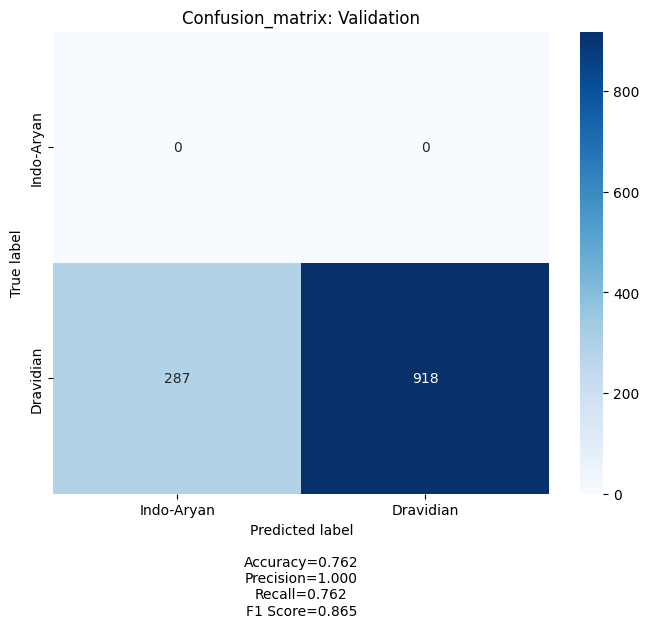

:::::Total validation loss 4.554742524498387, Training accuracy 100.0%, Validation accuracy 76.18257261410788% after 5 epochs
Epoch: 6, Batch: 0, Loss: 0.009488062001764774, Accuracy: 100.0%
Total training loss 0.00425771502959833 and training Accuracy 100.0% after 6 epochs
#####TEST--in-domain:::::Epoch: 6, Batch: 0, Loss: 3.7226223945617676, Accuracy:76.5625%


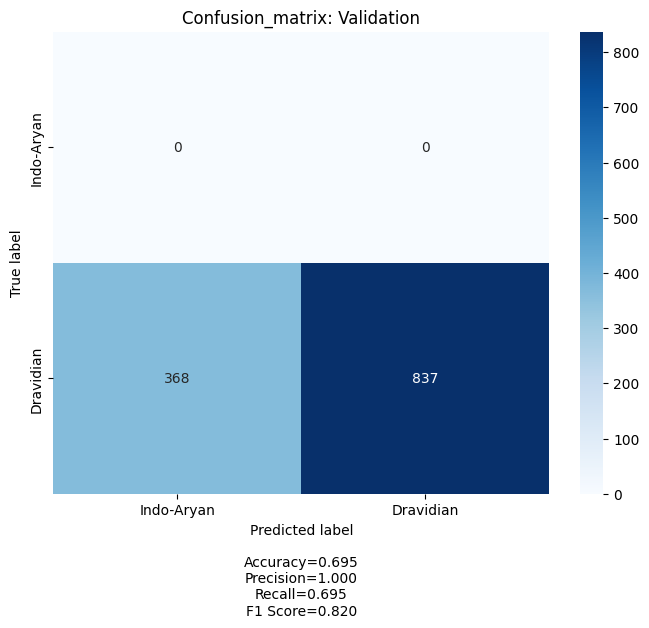

:::::Total validation loss 6.160667519820364, Training accuracy 100.0%, Validation accuracy 69.46058091286307% after 6 epochs
Epoch: 7, Batch: 0, Loss: 0.00010539594222791493, Accuracy: 100.0%
Total training loss 0.0002125812499798485 and training Accuracy 100.0% after 7 epochs
#####TEST--in-domain:::::Epoch: 7, Batch: 0, Loss: 5.9596476554870605, Accuracy:73.4375%


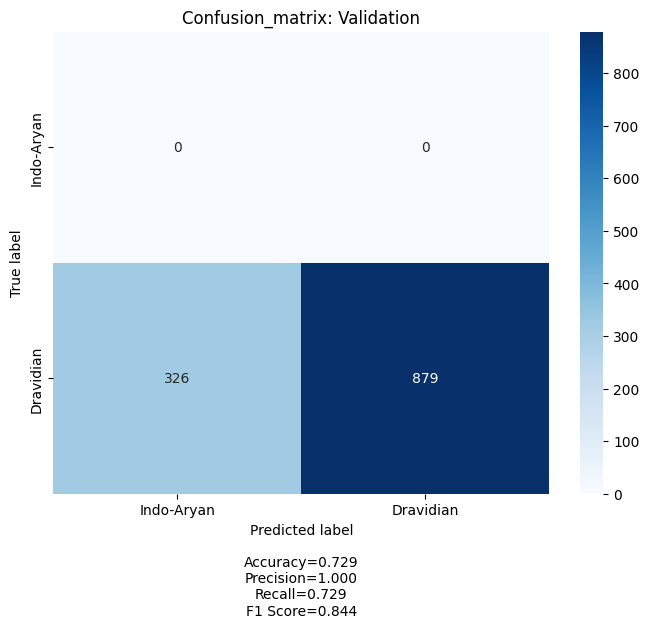

:::::Total validation loss 5.307308673858643, Training accuracy 100.0%, Validation accuracy 72.9460580912863% after 7 epochs
Epoch: 8, Batch: 0, Loss: 6.025374750606716e-05, Accuracy: 100.0%
Total training loss 0.0007153368582294206 and training Accuracy 100.0% after 8 epochs
#####TEST--in-domain:::::Epoch: 8, Batch: 0, Loss: 3.3136744499206543, Accuracy:82.8125%


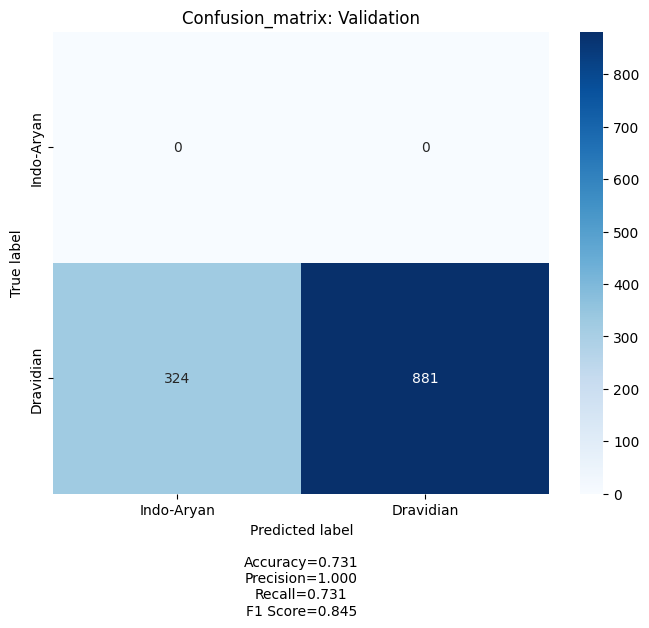

:::::Total validation loss 5.233715007179661, Training accuracy 100.0%, Validation accuracy 73.11203319502074% after 8 epochs
Epoch: 9, Batch: 0, Loss: 0.0003301598480902612, Accuracy: 100.0%
Total training loss 0.0012034422390570399 and training Accuracy 100.0% after 9 epochs
#####TEST--in-domain:::::Epoch: 9, Batch: 0, Loss: 6.4249138832092285, Accuracy:73.4375%


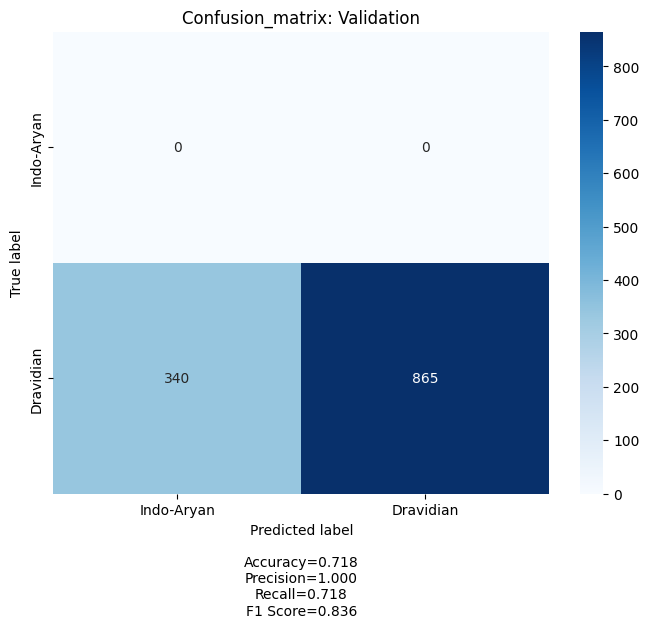

:::::Total validation loss 5.559102974439922, Training accuracy 100.0%, Validation accuracy 71.78423236514523% after 9 epochs
Epoch: 10, Batch: 0, Loss: 0.01328089740127325, Accuracy: 100.0%
Total training loss 0.0014001312410982791 and training Accuracy 100.0% after 10 epochs
#####TEST--in-domain:::::Epoch: 10, Batch: 0, Loss: 5.137884140014648, Accuracy:73.4375%


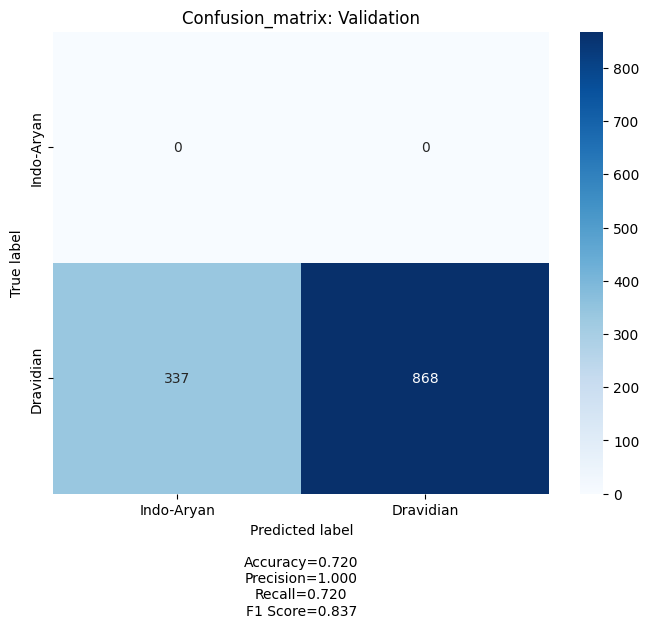

:::::Total validation loss 5.499929001456813, Training accuracy 100.0%, Validation accuracy 72.03319502074689% after 10 epochs
Epoch: 11, Batch: 0, Loss: 5.11773323523812e-05, Accuracy: 100.0%
Total training loss 0.0005424014958407497 and training Accuracy 100.0% after 11 epochs
#####TEST--in-domain:::::Epoch: 11, Batch: 0, Loss: 7.31353759765625, Accuracy:67.1875%


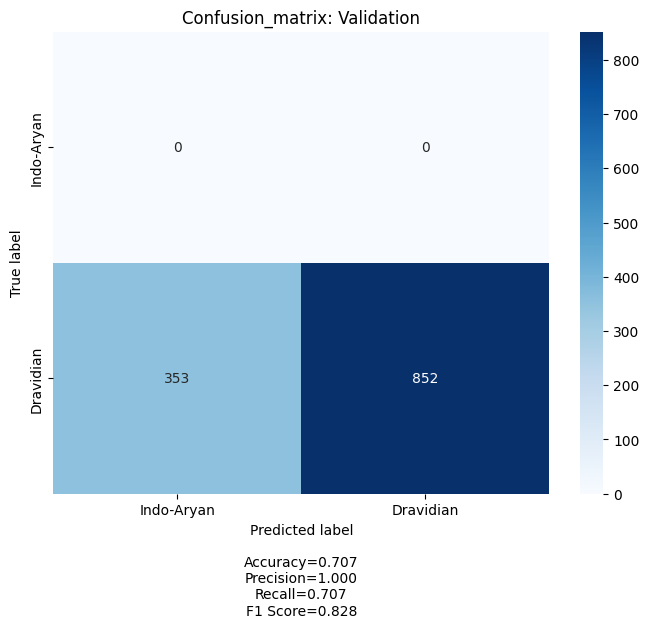

:::::Total validation loss 5.637968402159841, Training accuracy 100.0%, Validation accuracy 70.70539419087137% after 11 epochs
Epoch: 12, Batch: 0, Loss: 7.603577978443354e-05, Accuracy: 100.0%
Total training loss 0.0005962533903584699 and training Accuracy 100.0% after 12 epochs
#####TEST--in-domain:::::Epoch: 12, Batch: 0, Loss: 7.516838550567627, Accuracy:62.5%


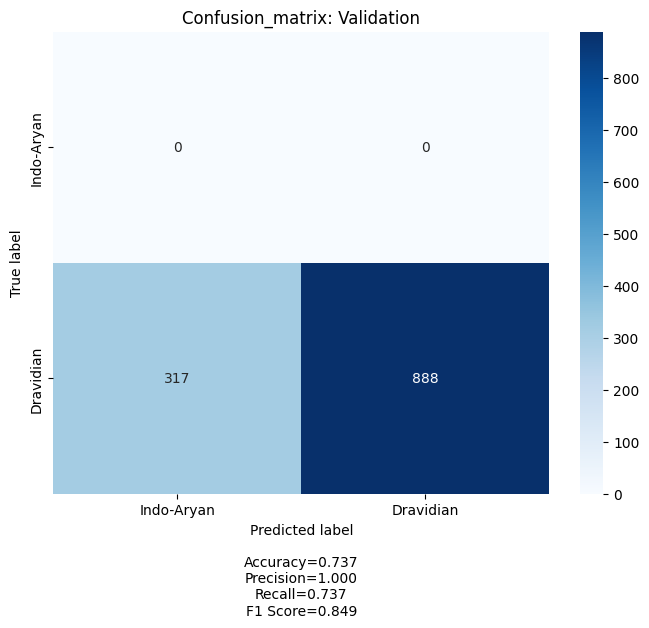

:::::Total validation loss 5.159519195556641, Training accuracy 100.0%, Validation accuracy 73.6929460580913% after 12 epochs
Epoch: 13, Batch: 0, Loss: 8.439182420261204e-05, Accuracy: 100.0%
Total training loss 0.00020975139113943442 and training Accuracy 100.0% after 13 epochs
#####TEST--in-domain:::::Epoch: 13, Batch: 0, Loss: 5.3911452293396, Accuracy:73.4375%


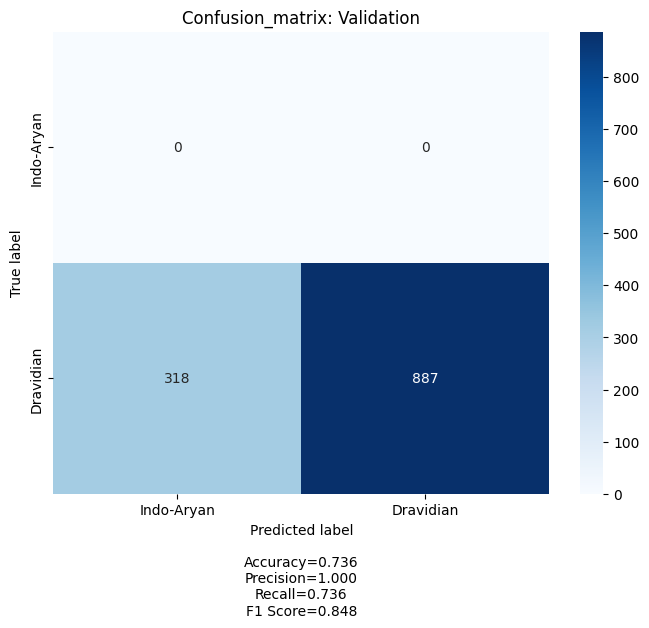

:::::Total validation loss 5.311369820644981, Training accuracy 100.0%, Validation accuracy 73.60995850622407% after 13 epochs
Epoch: 14, Batch: 0, Loss: 6.342814594972879e-05, Accuracy: 100.0%
Total training loss 0.00020476694999160827 and training Accuracy 100.0% after 14 epochs
#####TEST--in-domain:::::Epoch: 14, Batch: 0, Loss: 4.819653511047363, Accuracy:75.0%


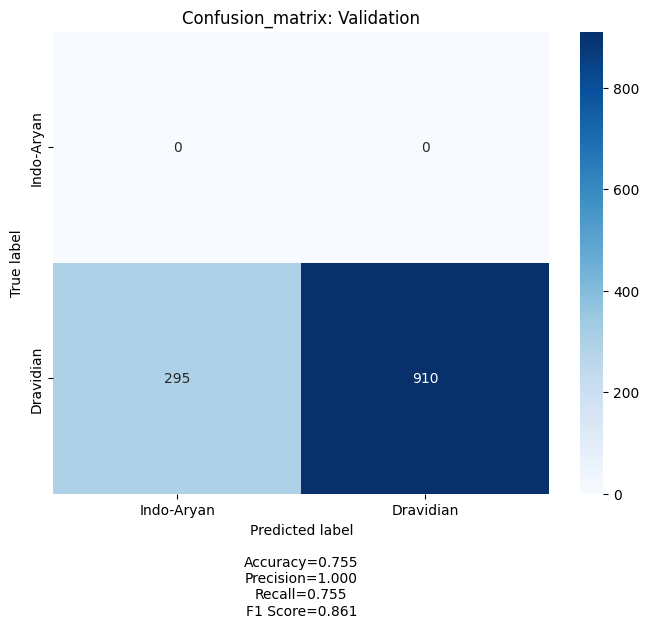

:::::Total validation loss 4.874521443718358, Training accuracy 100.0%, Validation accuracy 75.51867219917013% after 14 epochs
Epoch: 15, Batch: 0, Loss: 7.60395560064353e-05, Accuracy: 100.0%
Total training loss 0.00020297427163313843 and training Accuracy 100.0% after 15 epochs
#####TEST--in-domain:::::Epoch: 15, Batch: 0, Loss: 5.773360252380371, Accuracy:65.625%


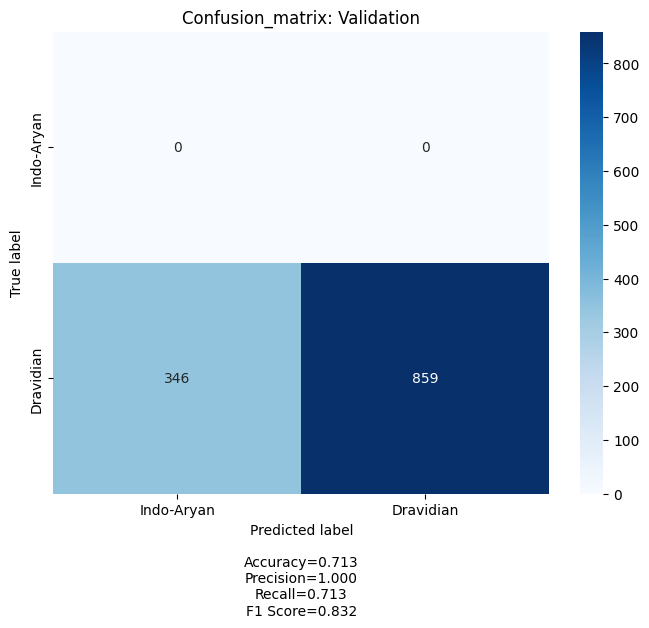

:::::Total validation loss 5.652527043693944, Training accuracy 100.0%, Validation accuracy 71.28630705394191% after 15 epochs
Epoch: 16, Batch: 0, Loss: 8.099337719613686e-05, Accuracy: 100.0%
Total training loss 0.00014272943008108996 and training Accuracy 100.0% after 16 epochs
#####TEST--in-domain:::::Epoch: 16, Batch: 0, Loss: 5.078463554382324, Accuracy:68.75%


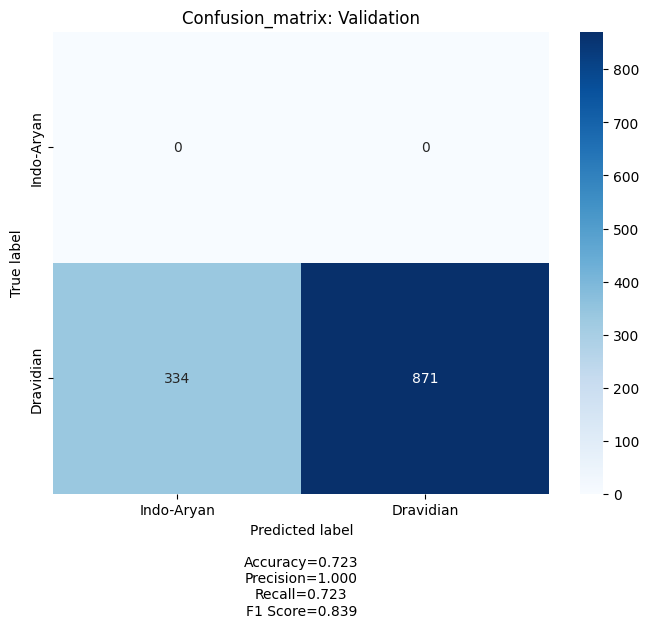

:::::Total validation loss 5.505108105508905, Training accuracy 100.0%, Validation accuracy 72.28215767634855% after 16 epochs
Epoch: 17, Batch: 0, Loss: 0.00017245284107048064, Accuracy: 100.0%
Total training loss 0.003884628179821448 and training Accuracy 99.98037291462218% after 17 epochs
#####TEST--in-domain:::::Epoch: 17, Batch: 0, Loss: 6.462032318115234, Accuracy:67.1875%


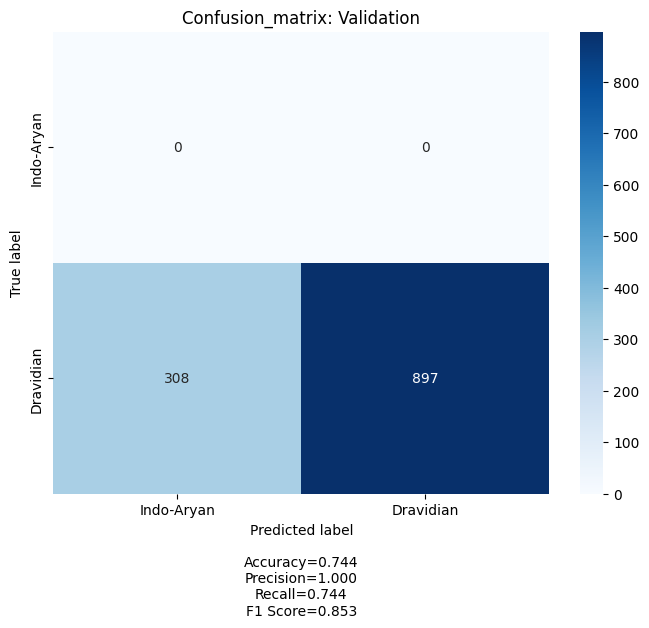

:::::Total validation loss 5.000909190428884, Training accuracy 99.98037291462218%, Validation accuracy 74.43983402489627% after 17 epochs
Epoch: 18, Batch: 0, Loss: 0.013227172195911407, Accuracy: 100.0%
Total training loss 0.00077706121483061 and training Accuracy 100.0% after 18 epochs
#####TEST--in-domain:::::Epoch: 18, Batch: 0, Loss: 4.136361122131348, Accuracy:78.125%


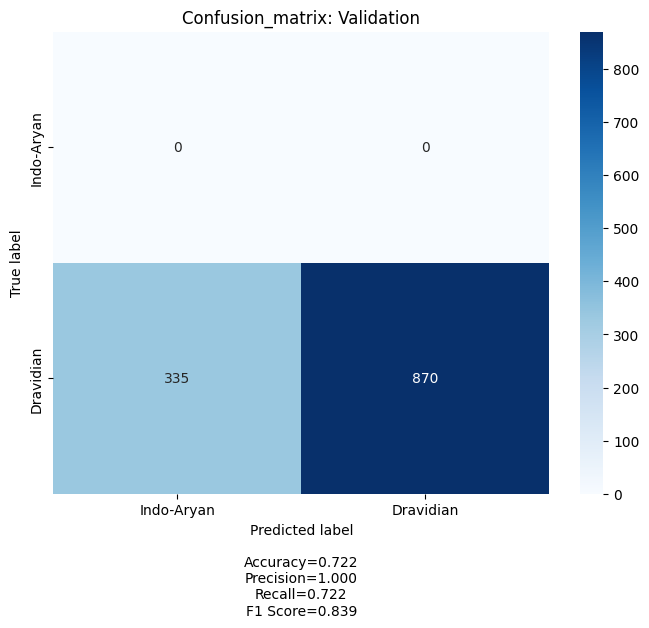

:::::Total validation loss 5.562380790710449, Training accuracy 100.0%, Validation accuracy 72.19917012448133% after 18 epochs
Epoch: 19, Batch: 0, Loss: 8.396917110076174e-05, Accuracy: 100.0%
Total training loss 0.0002709128480091749 and training Accuracy 100.0% after 19 epochs
#####TEST--in-domain:::::Epoch: 19, Batch: 0, Loss: 5.690834045410156, Accuracy:73.4375%


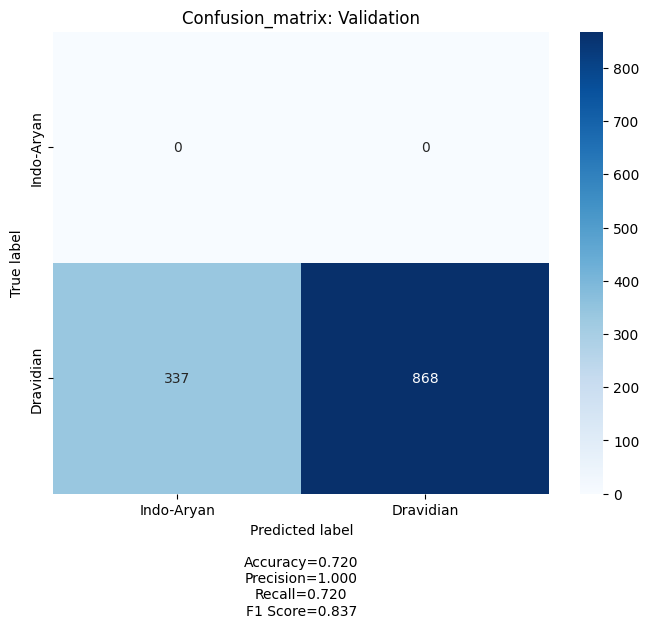

:::::Total validation loss 5.607641809865048, Training accuracy 100.0%, Validation accuracy 72.03319502074689% after 19 epochs
Epoch: 20, Batch: 0, Loss: 0.00018730336159933358, Accuracy: 100.0%
Total training loss 0.00014317056356958347 and training Accuracy 100.0% after 20 epochs
#####TEST--in-domain:::::Epoch: 20, Batch: 0, Loss: 6.415672302246094, Accuracy:70.3125%


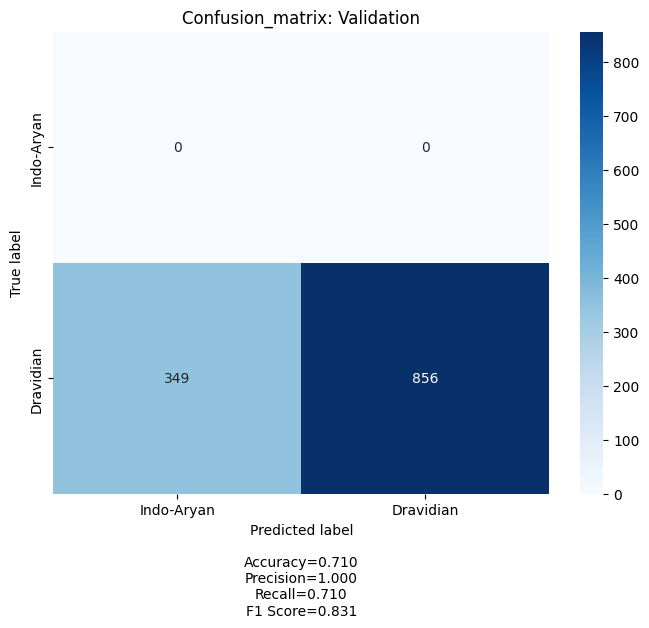

:::::Total validation loss 5.763488367984169, Training accuracy 100.0%, Validation accuracy 71.03734439834025% after 20 epochs


In [10]:
#For LR scheduler
import warnings
warnings.filterwarnings('ignore')
dest_path = "/home/bhagya/Data_Bhagya_internship_wav2vec_xlsr_IIITH_23L/"
os.makedirs(dest_path, exist_ok=True)

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import cf_matrix

def train(dataloader_train, epoch):
    train_loss_list = []
    train_acc_list = []
    full_preds = []
    full_gts = []

    model.train()
    for i_batch, data in enumerate(dataloader_train, 0):
        features, labels = data
        features, labels = features.to(device).float(), labels.to(device).long()
        features.requires_grad = True
        optimizer.zero_grad()
        pred_logits = model(features)
        loss = model.get_loss(pred_logits, labels)
        posterior = model.get_posterior()

        loss.backward()
        optimizer.step()
        predictions = np.argmax(posterior.detach().cpu().numpy(), axis=1)
        if i_batch % 50 == 0:
            acc = accuracy_score(predictions, labels.cpu())
            print(f"Epoch: {epoch}, Batch: {i_batch}, Loss: {loss}, Accuracy: {acc*100}%")
        train_loss_list.append(loss.item())
        full_preds.extend(predictions)
        full_gts.extend(labels.detach().cpu().numpy())

    mean_acc = accuracy_score(full_gts, full_preds)
    mean_loss = np.mean(np.asarray(train_loss_list))
    print(f'Total training loss {mean_loss} and training Accuracy {mean_acc*100}% after {epoch} epochs')
    return mean_acc

def validation(dataloader_val, epoch, train_accuracy):
    model.eval()
    with torch.no_grad():
        val_loss_list = []
        full_preds = []
        full_gts = []
        for i_batch, data in enumerate(dataloader_val, 0):
            features, labels = data
            features, labels = features.to(device).float(), labels.to(device).long()
            pred_logits = model(features)
            loss = model.get_loss(pred_logits, labels)
            posterior = model.get_posterior()
            val_loss_list.append(loss.item())
            predictions = np.argmax(posterior.detach().cpu().numpy(), axis=1)
            if i_batch % 50 == 0:
                acc = accuracy_score(predictions, labels.cpu())
                print(f"#####TEST--in-domain:::::Epoch: {epoch}, Batch: {i_batch}, Loss: {loss}, Accuracy:{acc*100}%")
            full_preds.extend(predictions)
            full_gts.extend(labels.detach().cpu().numpy())

        mean_acc2 = accuracy_score(full_gts, full_preds)
        mean_loss2 = np.mean(np.asarray(val_loss_list))
        cm = confusion_matrix(full_gts, full_preds)
        cf_matrix.make_confusion_matrix(cm, percent=False, figsize=(8, 6), categories=["Indo-Aryan", "Dravidian"], cbar=True, title="Confusion_matrix: Validation")
        plt.show()
        print(f':::::Total validation loss {mean_loss2}, Training accuracy {train_accuracy*100}%, Validation accuracy {mean_acc2*100}% after {epoch} epochs')
        model_save_path = os.path.join(dest_path, f'No_kannada_wav2vec_North_south_binary_Bhagya_ecapa_cms_{train_accuracy*100:.3f}_{mean_acc2*100:.3f}_{mean_loss2:.4f}')
        state_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': epoch}
        torch.save(state_dict, model_save_path)
        return loss

if __name__ == '__main__':
    for epoch in range(21):
        mean_acc = train(trainloader, epoch)
        val_loss = validation(testloader1, epoch, mean_acc)
        scheduler.step(val_loss)